**Introdution to Deep Learning - Final Project**

Authors:

Yohanan Aton 205600695

Liad Cohen 206727794

Dor Yarchi 205708225

**Attention**

In order to smoothly run our script, the only thing you shold do is to download 
a Kaggle SSH token, and upload it to your MAIN Google Drive folder. 

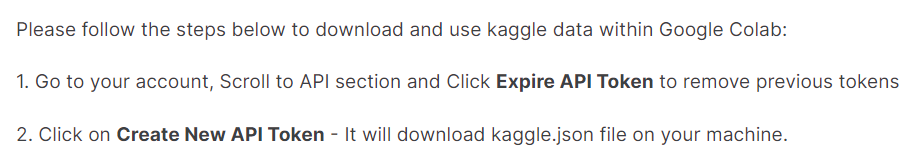


**Introduction**

In Today's world, we can witness the uprise in the field of autonomous vehicles. Developing autonomous vehicles rises many technological challenges, which require knowledge in many fields, with one of them being Computer Vision. Computer Vision allows autonomus vehicles to detect and recognize the surrounding objects - a crucial task for replacing human drivers.

Our project focuses on implementing a model for Traffic Signs Recognition, a technology which will be employed by the first generations of autonomous vehicles, based on the existing "human" traffic signs. In out project, we also try to analyze the impact of Data Augmentation on the performance of our model.


**Dataset**

We chose to use the following dataset from Kaggle:
https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

On the "DevOps" side, we managed to swiftly download and unzip the dataset to our Google Colab project.

The dataset contains images of 43 types (classes) of German traffic signs, mostly shot from the front. The classes' distribution is as follows:

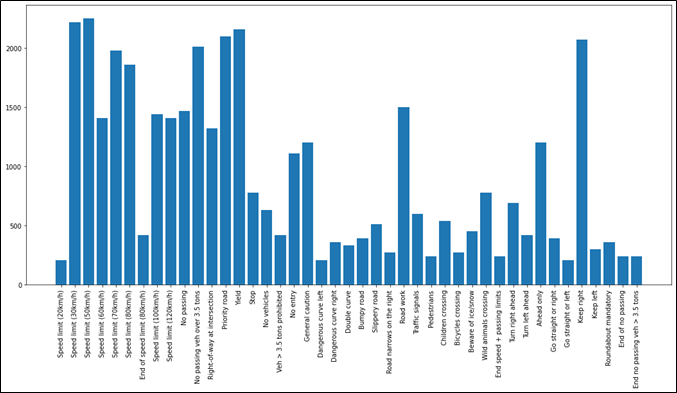

The images are in "Truecolor" .png format, where we have RGB channels, 8 bit each, which results in a total of 24 bit per pixel. The images' dimensions range from around 28*28 pixels (~0.0008 Megapixels) to around 120*120 pixels (~0.0144 Megapixels), so we decided to use OpenCV to resize all the training images to a uniform size of 32*32 pixels.

The training set contains 12632 images with the same properties.

Here are some examples for the original images in the dataset:

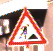

WhatsApp Image 2023-02-16 at 11.37.53.jpeg

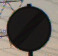

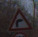

WhatsApp Image 2023-02-16 at 11.40.00.jpeg




**Limitations**

In the training set, each shot contains a sequence of images of the same sign, shot in adjacent time steps:
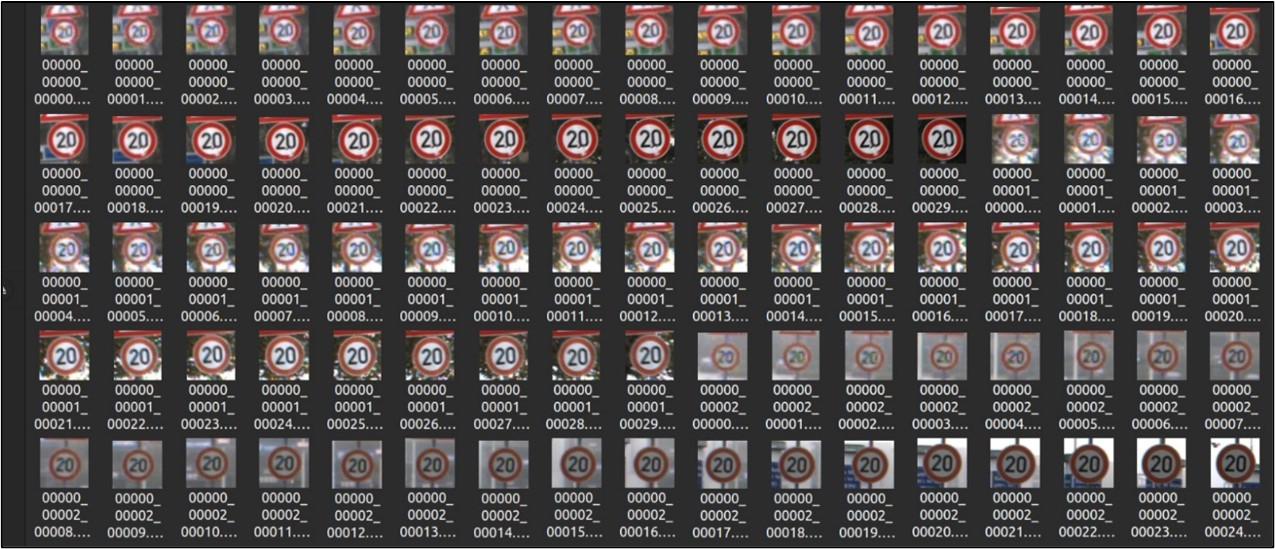

This is a major problem, because using images from the same sequence in both the training set and the validation set – will result in huge similarity between the sets, turning our validation set useless for examining the degree of Overfitting. 

Therefore, in order to create a significant difference between the training set and the validation set – we add to split the data by sequence. i.e., each sequence of images is assigned to either the final training set, or the validation set.

After splitting the data, we encountered another limitation, the small number of images in some of the classes. To handle this problem, we used PyTorch's ImageDataGenerator() class, to generate augmented images for our training set. We added images up to a total of 3000 for each class (but didn't necessarily use all of them every time we ran our model). Of course, the augmentation also enhances our model, and helps achieve better accuracy.

We chose to Pandas' DataFrame class to store store images in an organized fashion.

Here are some examples for the augmented images:

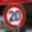

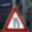

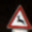

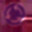

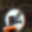



In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision.models import *
import scipy.misc
from torch.utils.data import  DataLoader
import torch.nn.functional as F
import random 
import torch.nn as nn
import math
import seaborn as sns
!pip install torchsummary 
!pip install ptflops
from torchsummary import summary


import torchvision.transforms as T
random.seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


explain what we did with kaggle#TODO complete

In [ ]:
# Download the dataset from Kaggle:

!pip install -q kaggle

# If it doesn't exist - Create a new folder named '~/.kaggle', copy the json to it:
!mkdir -p ~/.kaggle

!cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle

# Change permissions for json:
!chmod 600 .kaggle/kaggle.json

# Downloading dataset, and copying it to the KAGGLE folder:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

# Create a new folder named '_DATA', unzip dataset: 
if not os.path.exists('_DATA'):
  os.mkdir('_DATA')
  
!unzip gtsrb-german-traffic-sign.zip -d _DATA

chmod: cannot access '.kaggle/kaggle.json': No such file or directory
gtsrb-german-traffic-sign.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  gtsrb-german-traffic-sign.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of gtsrb-german-traffic-sign.zip or
        gtsrb-german-traffic-sign.zip.zip, and cannot find gtsrb-german-traffic-sign.zip.ZIP, period.


In [ ]:
# Gaussian Blur for the ImageDataGenerator:
def gaussBlur(img):
    return cv2.GaussianBlur(img, ksize = (3,3), sigmaX = 0)

In [ ]:
# CONSTANTS:
TARGET_IMGS_PER_LABEL = 3000
IMG_HEIGHT = 30
IMG_WIDTH = 30
COLOR_CH = 3
TRAIN_PATH = "_DATA/train"
NUM_OF_LABELS = len(os.listdir(TRAIN_PATH))

In [ ]:
# Important variables:
augGenerator = ImageDataGenerator(width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  brightness_range = [0.5, 0.9],
                                  shear_range = 0.1, # https://www.tutorialspoint.com/javafx/shearing_transformation
                                  zoom_range = 0.1,
                                  preprocessing_function = gaussBlur,
                                  fill_mode = 'nearest')


labels = {0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons'}

In [ ]:
# Create the necessary dirs:
if not os.path.exists('_DATA/Augmented'):
  os.mkdir('_DATA/Augmented')

for i in range(NUM_OF_LABELS):
    if not os.path.exists(f'_DATA/Augmented/{i}'):
      os.mkdir(f'_DATA/Augmented/{i}')

In [ ]:
# Start collecting data from folders:
imgDataTrain = []
imgLabelsTrain = []
imgDataVal = []
imgLabelsVal = []
imgsPerLabel = np.zeros(NUM_OF_LABELS)

folders = os.listdir(TRAIN_PATH)
#We go through all the classes
for folderName in folders:
    labelFolderPath = os.path.join(TRAIN_PATH, folderName)
    imgsPerLabel[int(folderName)] = len(os.listdir(labelFolderPath))
    imgListInLabel = os.listdir(labelFolderPath)
    #splitting the data to validation and train in the way described above.
    unique_sign = {int(f.split("_")[1]) for f in imgListInLabel if f.endswith(".png")}
    unique_sign = np.array([f for f in unique_sign])
    np.random.seed(42)
    np.random.shuffle(unique_sign)
    num_of_unique_sign = len(unique_sign)
    val_unique_sign = unique_sign[:num_of_unique_sign // 4]
    train_unique_sign = unique_sign[num_of_unique_sign // 4 :]

    for imgName in imgListInLabel:
        imgPath = os.path.join(labelFolderPath, imgName)
        img = cv2.imread(imgPath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (32, 32))
        img = np.array(img)
        if int(imgName.split("_")[1])  in train_unique_sign:
          imgDataTrain.append(img)
          imgLabelsTrain.append(int(folderName))
        if int(imgName.split("_")[1])  in val_unique_sign:
          imgDataVal.append(img)
          imgLabelsVal.append(int(folderName))

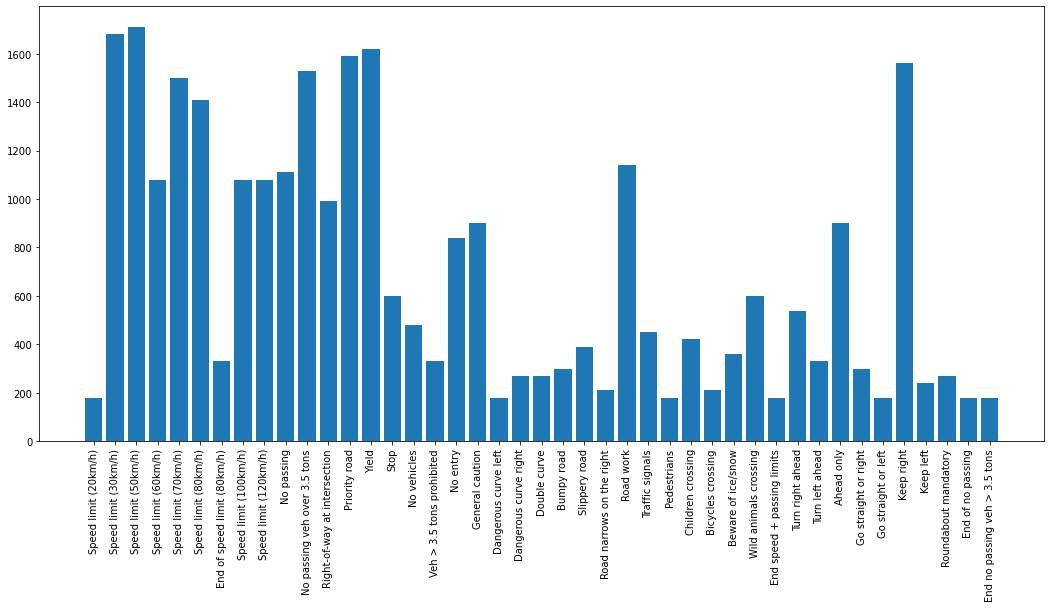



Label #0: imageDiff = 2820


***
Total train images from label #0:     3000
***

Label #1: imageDiff = 1320


***
Total train images from label #1:     3000
***

Label #2: imageDiff = 1290


***
Total train images from label #2:     3000
***

Label #3: imageDiff = 1920


***
Total train images from label #3:     3000
***

Label #4: imageDiff = 1500


***
Total train images from label #4:     3000
***

Label #5: imageDiff = 1590


***
Total train images from label #5:     3000
***

Label #6: imageDiff = 2670


***
Total train images from label #6:     3000
***

Label #7: imageDiff = 1920


***
Total train images from label #7:     3000
***

Label #8: imageDiff = 1920


***
Total train images from label #8:     3000
***

Label #9: imageDiff = 1890


***
Total train images from label #9:     3000
***

Label #10: imageDiff = 1470


***
Total train images from label #10:     3000
***

Label #11: imageDiff = 2010


***
Total train images from label #11:     3000
***

Label #12: imageDiff =

In [ ]:
# Adding images with data augmentation:
trainDf = pd.DataFrame({'Image': imgDataTrain, 'Label': imgLabelsTrain, 'Augmented': 0})
valDf = pd.DataFrame({'Image': imgDataVal, 'Label': imgLabelsVal, 'Augmented': 0})

# Count images by label in trainDf:
trainImgsPerLabel = np.zeros(NUM_OF_LABELS)
for i in range(NUM_OF_LABELS):
  trainImgsPerLabel[i] = len(trainDf.loc[trainDf['Label'] == i])

# Bar plot of the labels distribution within trainDf:
plt.figure(figsize=(18,8))  
plt.bar(list(labels.keys()), trainImgsPerLabel)
plt.xticks(ticks = list(labels.keys()),
           labels =  list(labels.values()), rotation='vertical')
plt.show()
print("\n")

# Add augmented images, up to a total of 3000 images in each label:
imgDiffPerLabel = TARGET_IMGS_PER_LABEL - trainImgsPerLabel

for i in range(NUM_OF_LABELS):
    imgDiff = int(imgDiffPerLabel[i])
    print(f"Label #{i}: imageDiff = {imgDiff}\n")
    augImgsForLabel = []

    rowsInLabel = trainDf.loc[trainDf['Label'] == i]
    imgsInLabel = rowsInLabel['Image'].values
    imgsInLabel = np.stack(imgsInLabel, axis = 0) # Change shape from 1-D to the required 4-D

    augIter = augGenerator.flow(x = imgsInLabel,
                                batch_size = 100,
                                shuffle = True,
                                save_to_dir = f"_DATA/Augmented/{i}",
                                save_prefix = "aug",
                                save_format = "png")

    while len(augImgsForLabel) < imgDiff:  # Sometimes, ImageDataGenerator fails to create 100 new images
        #print(f"Label #{i}: len(augImgsForLabel) = {len(augImgsForLabel)}")
        currentIter = next(augIter).astype('uint8') # Generate 100 new images from the current label
        currentIterImgList = [augImg for augImg in currentIter] # Extract them
        augImgsForLabel.extend(currentIterImgList) # Add to the current df

    augImgsDf = pd.DataFrame({'Image': augImgsForLabel[:imgDiff], 'Label': i, 'Augmented': 1})
    trainDf = pd.concat([trainDf, augImgsDf], ignore_index = True)
    print(f"\n***\nTotal train images from label #{i}: \
    {len(trainDf.loc[trainDf['Label'] == i])}\n***\n")

print(f"***Total no. of images in trainDf: {len(trainDf)}***")

In [ ]:
# input - num of augmentations, num of classes 
# output - dataset train
#this function add num_of_augmentaion to each class.
def data_train(num_of_augmentations, num_of_classes):
  data_set_train = []
  for i in range(num_of_classes):
    label = trainDf.loc[trainDf['Label'] == i] # loc - Filter by condition
    label_original = label.loc[label['Augmented'] == 0]
    label_aug = label.loc[label['Augmented'] == 1]
    label_aug_cut = label_aug.iloc[0:num_of_augmentations] # iloc - Filter by index
    label_original = label_original.append(label_aug_cut)
    imgsNN_per_label = np.stack(label_original['Image'], axis = 0) # 1D -> 4D
    imgsNN_per_label = torch.FloatTensor(imgsNN_per_label)
    imgsNN_per_label = imgsNN_per_label.permute(0, 3, 1, 2)
    labelsNN_per_label = label_original['Label'].to_numpy()
    labelsNN_per_label = torch.tensor(labelsNN_per_label)
    tuplesNN_per_label = [(imgsNN_per_label[j], labelsNN_per_label[j]) for j in range(len(imgsNN_per_label))] # Convert to list of tuples
    data_set_train.extend(tuplesNN_per_label)
  return data_set_train


In [ ]:
data_set_val = [] #Creating the validation dataset.
for i in range (NUM_OF_LABELS):
  val_label = valDf.loc[valDf['Label'] == i] # loc - Filter by condition
  #val_label = val_label.loc[val_label['Augmented'] == 0]
  val_imgsNN_per_label = np.stack(val_label['Image'], axis = 0) # 1D -> 4D
  val_imgsNN_per_label = torch.FloatTensor(val_imgsNN_per_label)
  val_imgsNN_per_label = val_imgsNN_per_label.permute(0, 3, 1, 2)
  val_labelsNN_per_label = val_label['Label'].to_numpy()
  val_labelsNN_per_label = torch.tensor(val_labelsNN_per_label)


  tuplesNN_per_label = [(val_imgsNN_per_label[j], val_labelsNN_per_label[j]) for j in range(len(val_labelsNN_per_label))] # Convert to list of tuples
  data_set_val.extend(tuplesNN_per_label)


The test data is stored inside a single folder and we have a csv file that has the the information of each test image, we go through the csv file in order to get the images by label.

In [ ]:
testids = {}
gt = pd.read_csv(os.path.join("_DATA/Test.csv"))
for index, row in gt.iterrows():
  path = os.path.join("_DATA/", row["Path"])
  if os.path.isfile(path):
    label = row["ClassId"]
    try:
      testids[label] += [path]
    except:
      testids[label] = [path]
  else:
     assert False

In [ ]:
#using the test ids to get to create the test datatset.
img_test_Data = []
img_test_Labels = []
imgs_test_PerLabel = np.zeros(NUM_OF_LABELS)
for i in range (NUM_OF_LABELS):
  imgs_test_PerLabel[i] = len(testids[i])
  for j in range (len(testids[i])):
    img_test = cv2.imread(testids[i][j])
    img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
    img_test = cv2.resize(img_test, (32, 32))
    img_test = np.array(img_test)
    img_test_Data.append(img_test)
    img_test_Labels.append(int(i))
img_test_Data = torch.FloatTensor(img_test_Data)
img_test_Data = img_test_Data.permute(0, 3, 1, 2)
img_test_Labels = torch.tensor(img_test_Labels)
test_data = [(img_test_Data[j], img_test_Labels[j]) for j in range(len(img_test_Labels))]
print(len(test_data))

12630


**Network**

In our network, we alternated between two components:

1)	CNN: As we learned, implies a convolutional filter on the image to extract important features. We used a kernel size of 3*3.

2)	Batch Normalization: Used to make the NN more stable and faster with 
Regularization. It is done by "recentering" and "rescaling" each input according to the mean and variance of the current batch.

3) Max Pooling: splits the input into blocks, and chooses the maximum value from
each block. This sort of downsampling reduces computational cost and helps reduce Overfitting by simplyfing the convolution results.

##The output dimensionality:
* for each Convolution layers:
## $dim_{i+1} =\lfloor(\frac{dim_{i}-Kernel Size+padding}{stride}-1 \rfloor )$ , ∀ i = 0,1,2,3
* The dimension will be reduced by 2 after max polling with kernel size of 2. 

For this reason, the input to the fully-connetected layer is of size 
## 8\*n_feature\*3\*3

For our activation function, we used RELU - a(x)=max(0,x).

Additionally, we used two linear transformation layers, and a "Dropout" layer – which randomly zeros some of the input elements, for further regularization of the network. In the overfitting problem, the model learns the statistical noise.
So in Overfitting, a unit may change in a way that fixes up the mistakes of the other units. This leads to co-adaptations, which in turn leads to the overfitting problem because this co-adaptation fails to generalise on the unseen dataset.
Now, if we use dropout, it prevents these units to fix up the mistake of other units, thus preventing co-adaptation and succeeds in overcoming overfitting.

Finally, we tested the effect of using our augmented data by integrating in our set varying numbers of augmented images. The amounts we tried are: [0, 200, 400, 500, 600, 700, 800, 900, 1000,1500,2000].


**First Ablation Model - 2 CNN layers:**

In [ ]:
class CNNwithTwoConvoulotions(nn.Module): # turn to sequential
    def __init__(self, input_size, n_feature, output_size):
        super(CNNwithTwoConvoulotions, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=3)
        self.batch_norm1 = nn.BatchNorm2d(n_feature)
        self.conv2 = nn.Conv2d(n_feature, 2*n_feature, kernel_size=3)
        self.batch_norm2 = nn.BatchNorm2d(2*n_feature)
        self.fc1 = nn.Linear(2*n_feature*6*6, 512)
        self.fc2 = nn.Linear(512, output_size)
        self.dropout = nn.Dropout(0.25)

        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.batch_norm1(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.batch_norm2(x)
        x = self.dropout(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*2*6*6)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [ ]:
summary(CNNwithTwoConvoulotions(input_size = 32*32,n_feature = 16,output_size = 43).to(device),(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
       BatchNorm2d-2           [-1, 16, 30, 30]              32
            Conv2d-3           [-1, 32, 13, 13]           4,640
       BatchNorm2d-4           [-1, 32, 13, 13]              64
           Dropout-5           [-1, 32, 13, 13]               0
            Linear-6                  [-1, 512]         590,336
           Dropout-7                  [-1, 512]               0
            Linear-8                   [-1, 43]          22,059
Total params: 617,579
Trainable params: 617,579
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.35
Params size (MB): 2.36
Estimated Total Size (MB): 2.72
----------------------------------------------------------------


**Second Ablation Model - No Dropout layer:**

In [ ]:
class CNNWithoutDropout(nn.Module): # turn to sequential
    def __init__(self, input_size, n_feature, output_size):
        super(CNNWithoutDropout, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=3)
        self.batch_norm1 = nn.BatchNorm2d(n_feature)
        self.conv2 = nn.Conv2d(n_feature, 2*n_feature, kernel_size=3)
        self.batch_norm2 = nn.BatchNorm2d(2*n_feature)
        self.conv3 = nn.Conv2d(2*n_feature, 4*n_feature, kernel_size=3)
        self.batch_norm3 = nn.BatchNorm2d(4*n_feature)
        self.conv4 = nn.Conv2d(4*n_feature, 8*n_feature, kernel_size=3)
        self.batch_norm4 = nn.BatchNorm2d(8*n_feature)
        self.fc1 = nn.Linear(8*n_feature*3*3, 512)
        self.fc2 = nn.Linear(512, output_size)

        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.batch_norm1(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.batch_norm2(x)
        x = self.conv3(x) 
        x = F.relu(x)
        x = self.batch_norm3(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv4(x) 
        x = F.relu(x)
        x = self.batch_norm4(x)
        x = x.view(-1, self.n_feature*8*3*3)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x


In [ ]:
summary(CNNWithoutDropout(input_size = 32*32,n_feature = 16,output_size = 43).to(device),(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
       BatchNorm2d-2           [-1, 16, 30, 30]              32
            Conv2d-3           [-1, 32, 13, 13]           4,640
       BatchNorm2d-4           [-1, 32, 13, 13]              64
            Conv2d-5           [-1, 64, 11, 11]          18,496
       BatchNorm2d-6           [-1, 64, 11, 11]             128
            Conv2d-7            [-1, 128, 3, 3]          73,856
       BatchNorm2d-8            [-1, 128, 3, 3]             256
            Linear-9                  [-1, 512]         590,336
           Linear-10                   [-1, 43]          22,059
Total params: 710,315
Trainable params: 710,315
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.44
Params size (MB): 2.71
Estimated T

**Third Ablation Model - Stride=2 and no MaxPooling:**

In [ ]:
class CNNWithStride(nn.Module): # turn to sequential
    def __init__(self, input_size, n_feature, output_size):
        super(CNNWithStride, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=3,stride =2)
        self.batch_norm1 = nn.BatchNorm2d(n_feature)
        self.conv2 = nn.Conv2d(n_feature, 2*n_feature, kernel_size=3)
        self.batch_norm2 = nn.BatchNorm2d(2*n_feature)
        self.conv3 = nn.Conv2d(2*n_feature, 4*n_feature, kernel_size=3 , stride =2)
        self.batch_norm3 = nn.BatchNorm2d(4*n_feature)
        self.conv4 = nn.Conv2d(4*n_feature, 8*n_feature, kernel_size=3)
        self.batch_norm4 = nn.BatchNorm2d(8*n_feature)
        self.fc1 = nn.Linear(8*n_feature*4*4, 512)
        self.fc2 = nn.Linear(512, output_size)
        self.dropout = nn.Dropout(0.25)

        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.batch_norm1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.batch_norm2(x)
        x = self.conv3(x) 
        x = F.relu(x)
        x = self.batch_norm3(x)
        x = self.dropout(x)
        x = self.conv4(x) 
        x = F.relu(x)
        x = self.batch_norm4(x)
        x = x.view(-1, self.n_feature*8*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x



In [ ]:
summary(CNNWithStride(input_size = 32*32,n_feature = 16,output_size = 43).to(device),(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 15, 15]             448
       BatchNorm2d-2           [-1, 16, 15, 15]              32
            Conv2d-3           [-1, 32, 13, 13]           4,640
       BatchNorm2d-4           [-1, 32, 13, 13]              64
            Conv2d-5             [-1, 64, 6, 6]          18,496
       BatchNorm2d-6             [-1, 64, 6, 6]             128
           Dropout-7             [-1, 64, 6, 6]               0
            Conv2d-8            [-1, 128, 4, 4]          73,856
       BatchNorm2d-9            [-1, 128, 4, 4]             256
           Linear-10                  [-1, 512]       1,049,088
          Dropout-11                  [-1, 512]               0
           Linear-12                   [-1, 43]          22,059
Total params: 1,169,067
Trainable params: 1,169,067
Non-trainable params: 0
---------------------------

**Optimal Model:**

In [ ]:
class CNNFinal(nn.Module): # turn to sequential
    def __init__(self, input_size, n_feature, output_size):
        super(CNNFinal, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=3)
        self.batch_norm1 = nn.BatchNorm2d(n_feature)
        self.conv2 = nn.Conv2d(n_feature, 2*n_feature, kernel_size=3)
        self.batch_norm2 = nn.BatchNorm2d(2*n_feature)
        self.conv3 = nn.Conv2d(2*n_feature, 4*n_feature, kernel_size=3)
        self.batch_norm3 = nn.BatchNorm2d(4*n_feature)
        self.conv4 = nn.Conv2d(4*n_feature, 8*n_feature, kernel_size=3)
        self.batch_norm4 = nn.BatchNorm2d(8*n_feature)
        self.fc1 = nn.Linear(8*n_feature*3*3, 512)
        self.fc2 = nn.Linear(512, output_size)
        self.dropout = nn.Dropout(0.25)

        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.batch_norm1(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.batch_norm2(x)
        x = self.conv3(x) 
        x = F.relu(x)
        x = self.batch_norm3(x)
        x = self.dropout(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv4(x) 
        x = F.relu(x)
        x = self.batch_norm4(x)
        x = x.view(-1, self.n_feature*8*3*3)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x



In [ ]:
summary(CNNFinal(input_size = 32*32,n_feature = 16,output_size = 43).to(device),(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
       BatchNorm2d-2           [-1, 16, 30, 30]              32
            Conv2d-3           [-1, 32, 13, 13]           4,640
       BatchNorm2d-4           [-1, 32, 13, 13]              64
            Conv2d-5           [-1, 64, 11, 11]          18,496
       BatchNorm2d-6           [-1, 64, 11, 11]             128
           Dropout-7           [-1, 64, 11, 11]               0
            Conv2d-8            [-1, 128, 3, 3]          73,856
       BatchNorm2d-9            [-1, 128, 3, 3]             256
           Linear-10                  [-1, 512]         590,336
          Dropout-11                  [-1, 512]               0
           Linear-12                   [-1, 43]          22,059
Total params: 710,315
Trainable params: 710,315
Non-trainable params: 0
-------------------------------

**Benchmark**

To evaluate our model, we used the following matrices: Categorical Cross Entropy loss, accuracy score, confusion matrix, and complementary 
plots. Most of the matrices were easily implemented with the PyTorch, while for out confusion matrix we used seaborn's (the Python package) heatmap() function.


In [ ]:
def train(model, traindataset, valdataset, print_outputs = True, epochs = 20):
    """
    input:model-the model we want to train.
    traindataset - list of tuples of image and labels of the training data.
    valdataset - list of tuples of image and labels of the validation data.
    print_outputs - whether or not we want to print output for every epoch.
    epochs - number of epochs
    
    output: Tuple of: last accuracy on traindata, last accuracy on valdata, list containing losshistory and accuracy history (empty if not printed)
    
    In each epoch the losses and accuracys are calculated for traindata and valdata. If print_outputs, they are appended to a list and also printed.
    
    
    """
    
    torch.manual_seed(42)
    torch.backends.cudnn.deterministic=True
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # trainloader is shuffled, valloader isnt. Changing Batch_size will change the results.
    trainloader = DataLoader(traindataset, batch_size=256, shuffle=True, drop_last = False, num_workers = 0, pin_memory = False)
    # batchsize of valloader can be increased to decrease time usage without changing results
    valloader = DataLoader(valdataset, batch_size= 512, shuffle=False, drop_last= False, num_workers = 0, pin_memory = False)

    #using Cross entroy loss
    criterion = nn.CrossEntropyLoss()  
    # initial learning rate is set to 0.001, which is the default value
    optimizer  = torch.optim.Adam(model.parameters(),lr = 0.001)
    # scheduler reduces learning rate to 1/1000 of the optimizers intial one, update is performed with each optimization step, so many times per epoch
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.0001, total_iters=len(trainloader)*epochs, last_epoch=- 1, verbose=False)

    val_losses = []
    val_accuracy = []
    train_losses = []
    train_accuracy = []
    for epoch in range(epochs):
        
        # counters for correct classifications and loss
        correct_train = 0
        correct_val = 0
        loss_train = 0
        loss_val = 0
        model.train()

        #Training 
        for inputs,labels in trainloader:
            optimizer.zero_grad()
            # data is sent to device (gpu)
            inputs = inputs.to(device)
            labels = labels.to(device)
            # inference of model on inputs
            outputs=model(inputs)
            # crossentropy between outputs and labels, note that labels is a 1d integer tensor with length batch-size and outputs is a 2d float tensor of size (batch_size x 43)
            loss = criterion(outputs, labels)
            loss_train += loss.item()
            loss.backward()
            optimizer.step()
            # this should be changed! this line determines the predicted index for each image by choosing the index with highest predicted value (probability)
            # i do not know the implementation of topk, so using argmax may be slightly faster, topk probably sorts by value and returns selected number of values from the front
            _,pred_idxs = torch.topk(outputs, 1)
            correct_train += torch.eq(labels, pred_idxs.squeeze()).sum().item()
            scheduler.step()
        acc_train = correct_train/len(traindataset)
        loss_train = loss_train/len(trainloader)

        if valdataset:
            model.eval()
            # set torch.no_grad() to not calculate gradients, because they would not be used
            with torch.no_grad():
                for inputs, labels in valloader: 
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss_val += loss.item()

                    _,pred_idxs = torch.topk(outputs, 1)
                    correct_val += torch.eq(labels, pred_idxs.squeeze()).sum().item()
        
            acc_val = correct_val/len(valdataset)
            loss_val = loss_val/len(valloader)
            val_losses.append(loss_val)
            val_accuracy.append(acc_val)
            train_losses.append(loss_train)
            train_accuracy.append(acc_train)
            if print_outputs:
                print(f"Epoch: {epoch}  Train_Accuracy: {acc_train}  Val_Accuracy: {acc_val} Loss: {loss_train} Val_Loss: {loss_val}")
    return acc_train, acc_val, train_losses, val_losses, train_accuracy, val_accuracy


In [ ]:
def plot_learning_curve(epcochs, train_losses,val_losses, train_accs, val_accs):
  """
  Plot the learning curves of loss and accuracy for train and validation.
  """
  plt.title("Learning Curve: Loss per Epoch")
  plt.plot(range(epcochs), train_losses, label="Train")
  plt.plot(range(epcochs), val_losses, label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()
  plt.title("Learning Curve: Accuracy per Epoch")
  plt.plot(range(epcochs), train_accs, label="Train")
  plt.plot(range(epcochs), val_accs, label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()


In [ ]:
#input trained model and test data.
#output the accuracy of the model on the test data.
def test_eval(model,test_data): 
  correct_test = 0
  model.eval
  with torch.no_grad():
    for i, data in enumerate(test_data, 0):
      inputs, test_labels =  data
      outputs = torch.stack([model(inputs.view(1,3,32,32).cuda(0))]).sum(0)
      _,pred_idxs = torch.topk(outputs, 1)
      correct_test += torch.eq(test_labels, pred_idxs.squeeze()).sum().item()
      accuracy = correct_test/len(test_data)
  return accuracy 

Testing the diffrent models for abalation study and to see which model yield the best results.

1. This is the first model we used it has only two layers of convoulotion.

Epoch: 0  Train_Accuracy: 0.7167575889420663  Val_Accuracy: 0.8871382636655949 Loss: 1.0433044870439758 Val_Loss: 0.43148327187487956
Epoch: 1  Train_Accuracy: 0.9667324877003916  Val_Accuracy: 0.9232583065380493 Loss: 0.1242135470557926 Val_Loss: 0.27687428881855386
Epoch: 2  Train_Accuracy: 0.9841360152615549  Val_Accuracy: 0.9260450160771704 Loss: 0.06081634468566149 Val_Loss: 0.27201387158742074
Epoch: 3  Train_Accuracy: 0.9909300846748552  Val_Accuracy: 0.9280814576634512 Loss: 0.03625874060532476 Val_Loss: 0.2799721333737436
Epoch: 4  Train_Accuracy: 0.9920680076307775  Val_Accuracy: 0.932475884244373 Loss: 0.028714763287168283 Val_Loss: 0.23751825633409776
Epoch: 5  Train_Accuracy: 0.9952809665651461  Val_Accuracy: 0.9382636655948553 Loss: 0.018634433456115488 Val_Loss: 0.2423838259358155
Epoch: 6  Train_Accuracy: 0.9959838013320392  Val_Accuracy: 0.9390139335476956 Loss: 0.014516584232895292 Val_Loss: 0.23419040010163658
Epoch: 7  Train_Accuracy: 0.9970213193212625  Val_Accurac

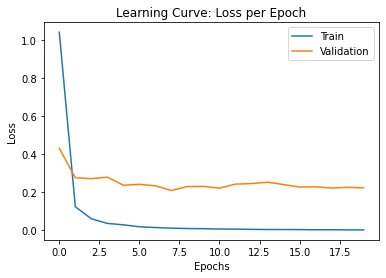

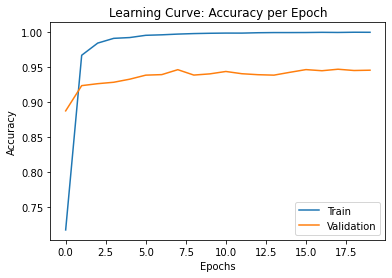

0.953285827395091


In [ ]:
model_cnn_withTwoConvoulotions = CNNwithTwoConvoulotions(32*32, 16, 43)
model_cnn_withTwoConvoulotions.to(device) 
Data_set_train = data_train(0, NUM_OF_LABELS)
acc_train, acc_val,train_losses, val_losses, train_accuracy, val_accuracy  = train(model_cnn_withTwoConvoulotions, traindataset = Data_set_train, valdataset = data_set_val, epochs=20)
test_accuracy = test_eval(model_cnn_withTwoConvoulotions,test_data)
plot_learning_curve(epcochs=20, train_losses = train_losses,val_losses = val_losses, train_accs = train_accuracy, val_accs = val_accuracy)
print(test_accuracy)  

2. The second model has all 4 layers and doesn't use Dropout:

Epoch: 0  Train_Accuracy: 0.8878141838749624  Val_Accuracy: 0.939978563772776 Loss: 0.4465965959760878 Val_Loss: 0.20113371729262566
Epoch: 1  Train_Accuracy: 0.9943438535426219  Val_Accuracy: 0.9504823151125402 Loss: 0.02239317888330318 Val_Loss: 0.18239275361166188
Epoch: 2  Train_Accuracy: 0.9993641018775729  Val_Accuracy: 0.9578778135048232 Loss: 0.0046917733051774334 Val_Loss: 0.1466519699284905
Epoch: 3  Train_Accuracy: 0.9992302285886409  Val_Accuracy: 0.9503751339764202 Loss: 0.003941815167876422 Val_Loss: 0.19185731579598628
Epoch: 4  Train_Accuracy: 0.999899595033301  Val_Accuracy: 0.9595927116827438 Loss: 0.0012256730902337064 Val_Loss: 0.1538530317576308
Epoch: 5  Train_Accuracy: 1.0  Val_Accuracy: 0.9607717041800643 Loss: 0.0003548109455931629 Val_Loss: 0.1440623805515076
Epoch: 6  Train_Accuracy: 1.0  Val_Accuracy: 0.9609860664523044 Loss: 0.00024307398174035674 Val_Loss: 0.14218053265817857
Epoch: 7  Train_Accuracy: 1.0  Val_Accuracy: 0.9615219721329046 Loss: 0.000184962

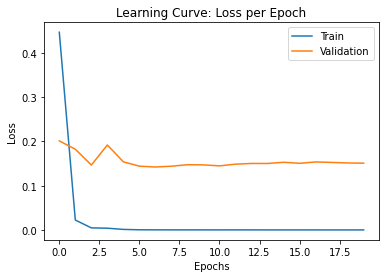

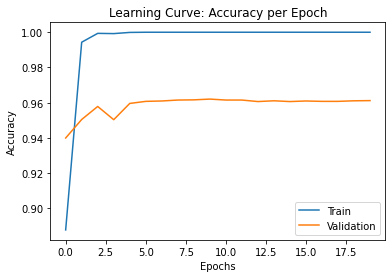

0.963895486935867


In [ ]:
model_cnn_wo_drop = CNNWithoutDropout(32*32, 16, 43)
model_cnn_wo_drop.to(device) 
Data_set_train = data_train(0, NUM_OF_LABELS)
acc_train, acc_val,train_losses, val_losses, train_accuracy, val_accuracy  = train(model_cnn_wo_drop, traindataset = Data_set_train, valdataset = data_set_val, epochs=20)
test_accuracy = test_eval(model_cnn_wo_drop,test_data)
plot_learning_curve(epcochs=20, train_losses = train_losses,val_losses = val_losses, train_accs = train_accuracy, val_accs = val_accuracy)
print(test_accuracy)  

3. The third model uses stride=2 instead of maxpooling in order to determine which method yields the best results:

Epoch: 0  Train_Accuracy: 0.8581612503765186  Val_Accuracy: 0.9222936763129689 Loss: 0.5271033281062403 Val_Loss: 0.25939184897824336
Epoch: 1  Train_Accuracy: 0.984102546939322  Val_Accuracy: 0.9354769560557342 Loss: 0.057273637622785874 Val_Loss: 0.21834731680390082
Epoch: 2  Train_Accuracy: 0.9929716523310687  Val_Accuracy: 0.9445873526259378 Loss: 0.025780502225184798 Val_Loss: 0.20056425064410033
Epoch: 3  Train_Accuracy: 0.9956156497874762  Val_Accuracy: 0.9439442658092175 Loss: 0.01506003844909943 Val_Loss: 0.21671107823127195
Epoch: 4  Train_Accuracy: 0.9963854211988353  Val_Accuracy: 0.9498392282958199 Loss: 0.011636456290586319 Val_Loss: 0.17532536387443542
Epoch: 5  Train_Accuracy: 0.9975233441547575  Val_Accuracy: 0.9523043944265809 Loss: 0.00995272465953683 Val_Loss: 0.19611066726869658
Epoch: 6  Train_Accuracy: 0.9983935205328157  Val_Accuracy: 0.9479099678456592 Loss: 0.006341787061602291 Val_Loss: 0.19237106842430016
Epoch: 7  Train_Accuracy: 0.9990628869774758  Val_Acc

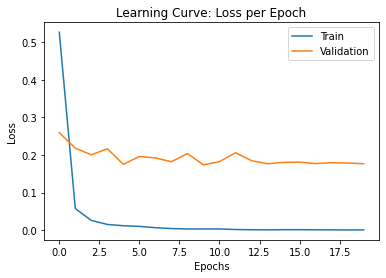

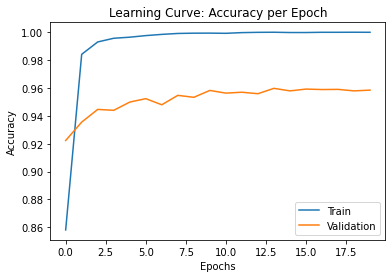

0.9566112430720507


In [ ]:
model_cnn_withStride = CNNWithStride(32*32, 16, 43)
model_cnn_withStride.to(device) 
Data_set_train = data_train(0, NUM_OF_LABELS)
acc_train, acc_val,train_losses, val_losses, train_accuracy, val_accuracy  = train(model_cnn_withStride, traindataset = Data_set_train, valdataset = data_set_val, epochs=20)
test_accuracy = test_eval(model_cnn_withStride,test_data)
plot_learning_curve(epcochs=20, train_losses = train_losses,val_losses = val_losses, train_accs = train_accuracy, val_accs = val_accuracy)
print(test_accuracy)  

And we can see that our model yields the best results:

Epoch: 0  Train_Accuracy: 0.8563204926537032  Val_Accuracy: 0.9293676312968917 Loss: 0.5584269150072693 Val_Loss: 0.22530216262920907
Epoch: 1  Train_Accuracy: 0.9888885170186419  Val_Accuracy: 0.9465166130760986 Loss: 0.040199623928747624 Val_Loss: 0.1748201334849
Epoch: 2  Train_Accuracy: 0.9950801566317481  Val_Accuracy: 0.9569131832797427 Loss: 0.018918177037316766 Val_Loss: 0.15953497995475405
Epoch: 3  Train_Accuracy: 0.9969878509990294  Val_Accuracy: 0.9571275455519829 Loss: 0.01170142942195774 Val_Loss: 0.1614905455590863
Epoch: 4  Train_Accuracy: 0.9968539777100974  Val_Accuracy: 0.9562700964630225 Loss: 0.011702601849618886 Val_Loss: 0.18354752855865578
Epoch: 5  Train_Accuracy: 0.9987282037551457  Val_Accuracy: 0.9558413719185423 Loss: 0.005684095039330901 Val_Loss: 0.20979737294347664
Epoch: 6  Train_Accuracy: 0.9992636969108739  Val_Accuracy: 0.967524115755627 Loss: 0.0030516007515645595 Val_Loss: 0.14126097342293514
Epoch: 7  Train_Accuracy: 0.9993975701998059  Val_Accura

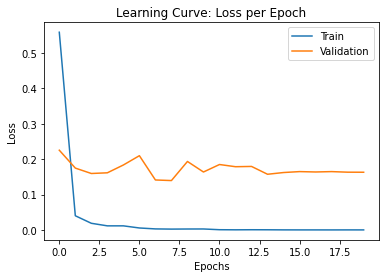

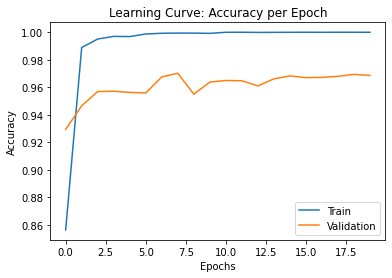

0.9672209026128266


In [ ]:
model_cnn = CNNFinal(32*32, 16, 43)
model_cnn.to(device) 
Data_set_train = data_train(0, NUM_OF_LABELS)
acc_train, acc_val,train_losses, val_losses, train_accuracy, val_accuracy  = train(model_cnn, traindataset = Data_set_train, valdataset = data_set_val, epochs=20)
test_accuracy = test_eval(model_cnn,test_data)
plot_learning_curve(epcochs=20, train_losses = train_losses,val_losses = val_losses, train_accs = train_accuracy, val_accs = val_accuracy)
print(test_accuracy)  

---------------------Num of augmentations:0---------------------------
Epoch: 0  Train_Accuracy: 0.8563204926537032  Val_Accuracy: 0.9293676312968917 Loss: 0.5584269150072693 Val_Loss: 0.22530216262920907
Epoch: 1  Train_Accuracy: 0.9888885170186419  Val_Accuracy: 0.9465166130760986 Loss: 0.040199623928747624 Val_Loss: 0.1748201334849
Epoch: 2  Train_Accuracy: 0.9950801566317481  Val_Accuracy: 0.9569131832797427 Loss: 0.018918177037316766 Val_Loss: 0.15953497995475405
Epoch: 3  Train_Accuracy: 0.9969878509990294  Val_Accuracy: 0.9571275455519829 Loss: 0.01170142942195774 Val_Loss: 0.1614905455590863
Epoch: 4  Train_Accuracy: 0.9968539777100974  Val_Accuracy: 0.9562700964630225 Loss: 0.011702601849618886 Val_Loss: 0.18354752855865578
Epoch: 5  Train_Accuracy: 0.9987282037551457  Val_Accuracy: 0.9558413719185423 Loss: 0.005684095039330901 Val_Loss: 0.20979737294347664
Epoch: 6  Train_Accuracy: 0.9992636969108739  Val_Accuracy: 0.967524115755627 Loss: 0.0030516007515645595 Val_Loss: 0.141

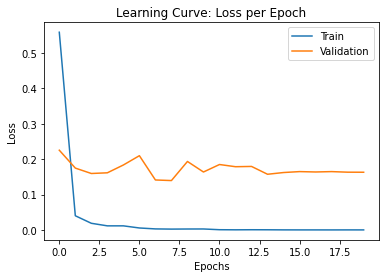

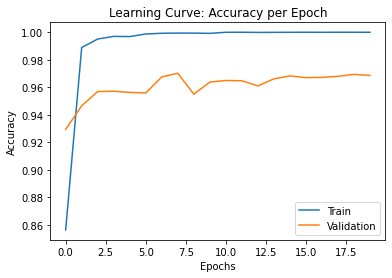

Acuracies for 0 Augmentations:Train accuracy achieved : 0.999966531677767 Validation accuracy achieved : 0.9685959271168274 Test accuracy achieved: 0.9672209026128266
---------------------Num of augmentations:200---------------------------
Epoch: 0  Train_Accuracy: 0.8194079887730971  Val_Accuracy: 0.9368703108252947 Loss: 0.6661662747034963 Val_Loss: 0.20261362204818348
Epoch: 1  Train_Accuracy: 0.9681384651368279  Val_Accuracy: 0.9547695605573419 Loss: 0.10792251974837669 Val_Loss: 0.19026189454291997
Epoch: 2  Train_Accuracy: 0.9848228904077548  Val_Accuracy: 0.9612004287245445 Loss: 0.04930399696879237 Val_Loss: 0.17336216167007623
Epoch: 3  Train_Accuracy: 0.9903583772967073  Val_Accuracy: 0.9673097534833869 Loss: 0.03269574730749557 Val_Loss: 0.13046248671353647
Epoch: 4  Train_Accuracy: 0.9946204423191871  Val_Accuracy: 0.9687031082529475 Loss: 0.01953344367327329 Val_Loss: 0.1561288488048472
Epoch: 5  Train_Accuracy: 0.9944125367083344  Val_Accuracy: 0.9693461950696678 Loss: 0.

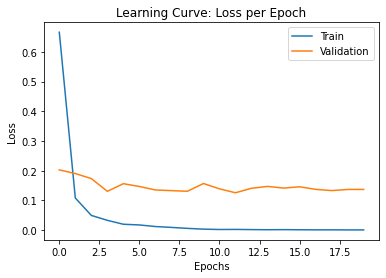

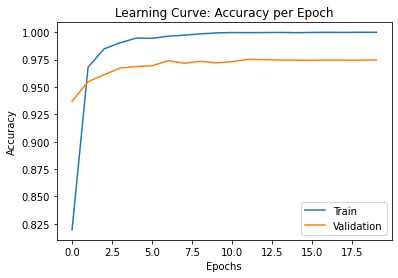

Acuracies for 200 Augmentations:Train accuracy achieved : 0.9999480235972869 Validation accuracy achieved : 0.9748124330117899 Test accuracy achieved: 0.971575613618369
---------------------Num of augmentations:400---------------------------
Epoch: 0  Train_Accuracy: 0.8208330678221712  Val_Accuracy: 0.9264737406216506 Loss: 0.6398529273903241 Val_Loss: 0.2245451753812009
Epoch: 1  Train_Accuracy: 0.972599248072389  Val_Accuracy: 0.9588424437299036 Loss: 0.09186196337332544 Val_Loss: 0.18467147011113794
Epoch: 2  Train_Accuracy: 0.9877015229720257  Val_Accuracy: 0.9616291532690247 Loss: 0.04171018868826492 Val_Loss: 0.14773051961521177
Epoch: 3  Train_Accuracy: 0.9921196287091909  Val_Accuracy: 0.9706323687031082 Loss: 0.025867105193395655 Val_Loss: 0.11344603150102653
Epoch: 4  Train_Accuracy: 0.9955181715839334  Val_Accuracy: 0.9689174705251876 Loss: 0.015716211402120636 Val_Loss: 0.12559495578323931
Epoch: 5  Train_Accuracy: 0.9966651798041589  Val_Accuracy: 0.9679528403001072 Loss:

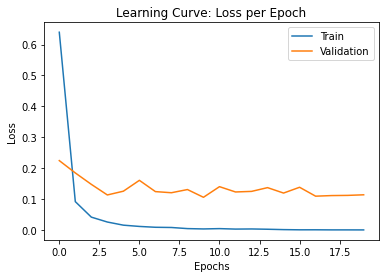

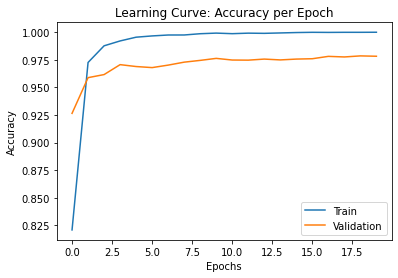

Acuracies for 400 Augmentations:Train accuracy achieved : 1.0 Validation accuracy achieved : 0.9782422293676313 Test accuracy achieved: 0.972209026128266
---------------------Num of augmentations:500---------------------------
Epoch: 0  Train_Accuracy: 0.8252009575896767  Val_Accuracy: 0.952411575562701 Loss: 0.6227354382845893 Val_Loss: 0.16006675100346146
Epoch: 1  Train_Accuracy: 0.9763716693590767  Val_Accuracy: 0.9638799571275456 Loss: 0.08052304820783103 Val_Loss: 0.11825569302431847
Epoch: 2  Train_Accuracy: 0.9881663714747271  Val_Accuracy: 0.9646302250803859 Loss: 0.03939232667120387 Val_Loss: 0.14212983094866535
Epoch: 3  Train_Accuracy: 0.992000622822554  Val_Accuracy: 0.9653804930332262 Loss: 0.025768879946988465 Val_Loss: 0.1275047473027371
Epoch: 4  Train_Accuracy: 0.9957570213511356  Val_Accuracy: 0.9695605573419078 Loss: 0.014979764477428586 Val_Loss: 0.123466206818672
Epoch: 5  Train_Accuracy: 0.996477159929154  Val_Accuracy: 0.9758842443729904 Loss: 0.0130846658964822

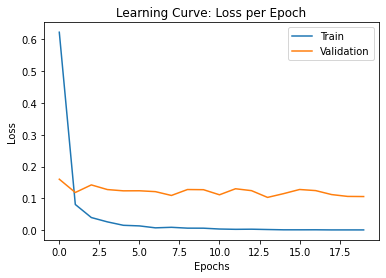

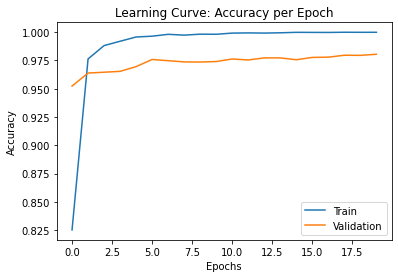

Acuracies for 500 Augmentations:Train accuracy achieved : 0.9999221471807548 Validation accuracy achieved : 0.9804930332261522 Test accuracy achieved: 0.9753760886777514
---------------------Num of augmentations:600---------------------------
Epoch: 0  Train_Accuracy: 0.8250866574471525  Val_Accuracy: 0.9467309753483387 Loss: 0.6194387492510157 Val_Loss: 0.1748732163717872
Epoch: 1  Train_Accuracy: 0.9769392410064835  Val_Accuracy: 0.9595927116827438 Loss: 0.07783267617123116 Val_Loss: 0.16575118754745313
Epoch: 2  Train_Accuracy: 0.9890802636541605  Val_Accuracy: 0.9693461950696678 Loss: 0.036531226480926535 Val_Loss: 0.132356892830055
Epoch: 3  Train_Accuracy: 0.9937498877494207  Val_Accuracy: 0.9684887459807074 Loss: 0.021939393412749017 Val_Loss: 0.13391897201194966
Epoch: 4  Train_Accuracy: 0.9952764956267174  Val_Accuracy: 0.9718113612004288 Loss: 0.015997431847617167 Val_Loss: 0.1278780610729499
Epoch: 5  Train_Accuracy: 0.9968031035040141  Val_Accuracy: 0.9682743837084673 Loss:

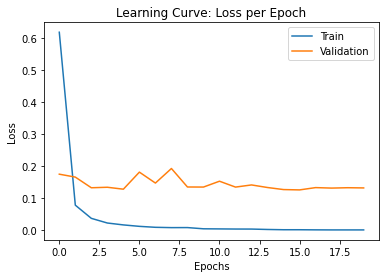

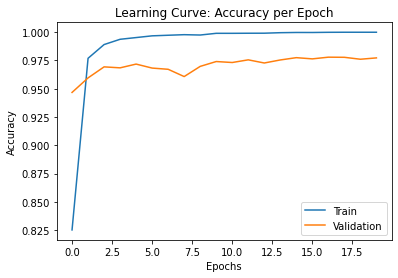

Acuracies for 600 Augmentations:Train accuracy achieved : 0.9999820399073259 Validation accuracy achieved : 0.9772775991425509 Test accuracy achieved: 0.976326207442597
---------------------Num of augmentations:700---------------------------
Epoch: 0  Train_Accuracy: 0.8333916870904816  Val_Accuracy: 0.9371918542336549 Loss: 0.581562697697193 Val_Loss: 0.21527604758739471
Epoch: 1  Train_Accuracy: 0.9768252221610897  Val_Accuracy: 0.9616291532690247 Loss: 0.07607864611484903 Val_Loss: 0.14507842821216113
Epoch: 2  Train_Accuracy: 0.9884459560846296  Val_Accuracy: 0.9661307609860664 Loss: 0.03653732565568483 Val_Loss: 0.1292915900580977
Epoch: 3  Train_Accuracy: 0.9939978992647427  Val_Accuracy: 0.9632368703108253 Loss: 0.02059680070391202 Val_Loss: 0.14577737279040248
Epoch: 4  Train_Accuracy: 0.9961319795261675  Val_Accuracy: 0.9669882100750268 Loss: 0.013472335660295124 Val_Loss: 0.15572634411632622
Epoch: 5  Train_Accuracy: 0.9955984594608113  Val_Accuracy: 0.9689174705251876 Loss: 

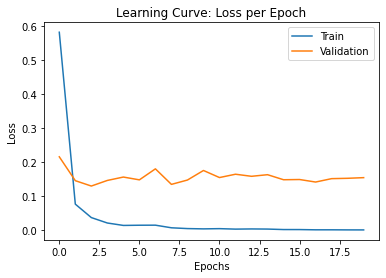

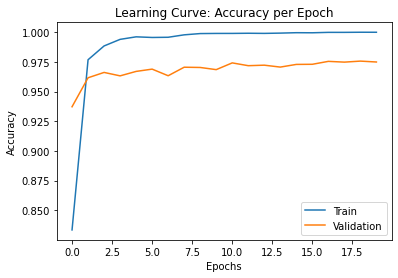

Acuracies for 700 Augmentations:Train accuracy achieved : 0.9999833274979576 Validation accuracy achieved : 0.97491961414791 Test accuracy achieved: 0.9750593824228029
---------------------Num of augmentations:800---------------------------
Epoch: 0  Train_Accuracy: 0.8415656746371287  Val_Accuracy: 0.9505894962486602 Loss: 0.5561777169535321 Val_Loss: 0.16786853361286616
Epoch: 1  Train_Accuracy: 0.9790289207983945  Val_Accuracy: 0.9587352625937835 Loss: 0.07042591192478699 Val_Loss: 0.15753035182378403
Epoch: 2  Train_Accuracy: 0.9907123632912771  Val_Accuracy: 0.9587352625937835 Loss: 0.032229329302300894 Val_Loss: 0.18355835801431616
Epoch: 3  Train_Accuracy: 0.9936993419312684  Val_Accuracy: 0.9673097534833869 Loss: 0.02039313746527547 Val_Loss: 0.16428268880669125
Epoch: 4  Train_Accuracy: 0.9936215560291852  Val_Accuracy: 0.9708467309753483 Loss: 0.020314466597656497 Val_Loss: 0.15177786049102188
Epoch: 5  Train_Accuracy: 0.9959395759112618  Val_Accuracy: 0.9735262593783494 Loss

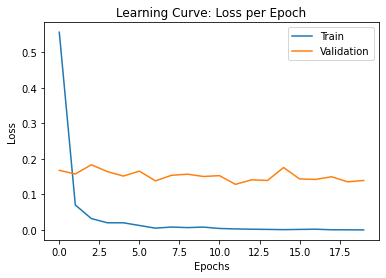

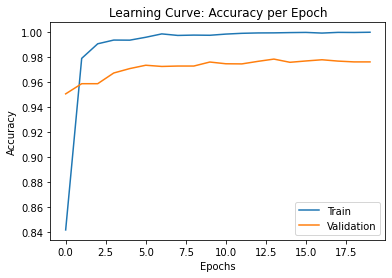

Acuracies for 800 Augmentations:Train accuracy achieved : 0.9999688856391667 Validation accuracy achieved : 0.9762057877813505 Test accuracy achieved: 0.9770387965162312
---------------------Num of augmentations:900---------------------------
Epoch: 0  Train_Accuracy: 0.8439172341387305  Val_Accuracy: 0.9445873526259378 Loss: 0.5471894154186124 Val_Loss: 0.23379890248179436
Epoch: 1  Train_Accuracy: 0.9816270286822497  Val_Accuracy: 0.9523043944265809 Loss: 0.06226245699617178 Val_Loss: 0.20689390026228993
Epoch: 2  Train_Accuracy: 0.9891949430583706  Val_Accuracy: 0.9659163987138264 Loss: 0.03441479377823868 Val_Loss: 0.16094408474715524
Epoch: 3  Train_Accuracy: 0.9936423686551277  Val_Accuracy: 0.9636655948553055 Loss: 0.02058347081027077 Val_Loss: 0.2055566705959408
Epoch: 4  Train_Accuracy: 0.9952171947680777  Val_Accuracy: 0.9673097534833869 Loss: 0.016123738148555493 Val_Loss: 0.1723324782582686
Epoch: 5  Train_Accuracy: 0.9958879540384082  Val_Accuracy: 0.9663451232583066 Loss:

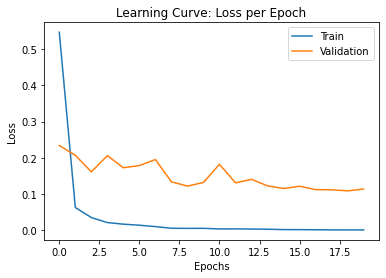

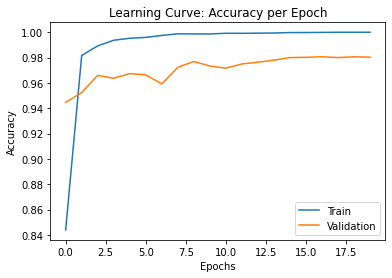

Acuracies for 900 Augmentations:Train accuracy achieved : 0.9999416731069278 Validation accuracy achieved : 0.9802786709539121 Test accuracy achieved: 0.9732383214568487
---------------------Num of augmentations:1000---------------------------
Epoch: 0  Train_Accuracy: 0.8550336859726396  Val_Accuracy: 0.9456591639871382 Loss: 0.5081832202641587 Val_Loss: 0.18492463686944624
Epoch: 1  Train_Accuracy: 0.9818466224838431  Val_Accuracy: 0.960021436227224 Loss: 0.06157993775253233 Val_Loss: 0.14493018429187177
Epoch: 2  Train_Accuracy: 0.9911771566569245  Val_Accuracy: 0.9561629153269025 Loss: 0.028333030498929716 Val_Loss: 0.1583896903933859
Epoch: 3  Train_Accuracy: 0.9933039695934357  Val_Accuracy: 0.9669882100750268 Loss: 0.02181115635066179 Val_Loss: 0.14865914805130542
Epoch: 4  Train_Accuracy: 0.995869866491033  Val_Accuracy: 0.9684887459807074 Loss: 0.013855783899085955 Val_Loss: 0.14140094718650767
Epoch: 5  Train_Accuracy: 0.9964598855637427  Val_Accuracy: 0.969989281886388 Loss:

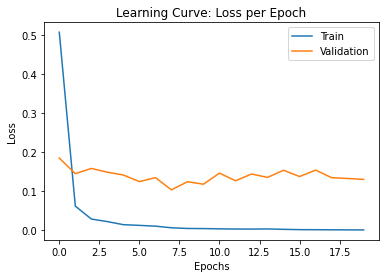

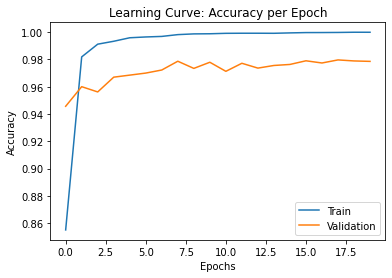

Acuracies for 1000 Augmentations:Train accuracy achieved : 0.9999039503835124 Validation accuracy achieved : 0.9785637727759914 Test accuracy achieved: 0.9743467933491686
---------------------Num of augmentations:1500---------------------------
Epoch: 0  Train_Accuracy: 0.877819167671765  Val_Accuracy: 0.9526259378349411 Loss: 0.4247027129403066 Val_Loss: 0.1894682025242793
Epoch: 1  Train_Accuracy: 0.9858040965321436  Val_Accuracy: 0.9615219721329046 Loss: 0.046307161044522795 Val_Loss: 0.15235084550620645
Epoch: 2  Train_Accuracy: 0.9923149996264236  Val_Accuracy: 0.9550911039657021 Loss: 0.024552846751735632 Val_Loss: 0.17737107644777433
Epoch: 3  Train_Accuracy: 0.9946204997384965  Val_Accuracy: 0.9670953912111468 Loss: 0.01733849799677811 Val_Loss: 0.16505409139331037
Epoch: 4  Train_Accuracy: 0.9959547011922424  Val_Accuracy: 0.9732047159699893 Loss: 0.012764881733331646 Val_Loss: 0.116340978800987
Epoch: 5  Train_Accuracy: 0.9964456873272209  Val_Accuracy: 0.9739549839228295 Los

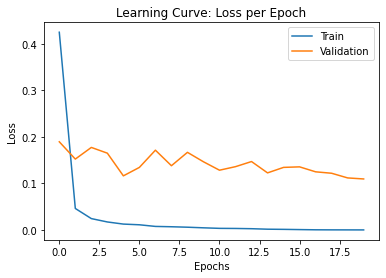

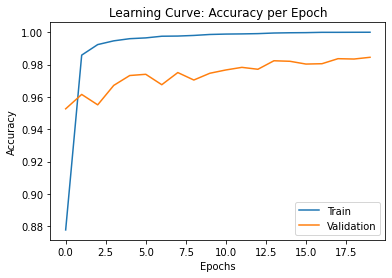

Acuracies for 1500 Augmentations:Train accuracy achieved : 0.9999359583302202 Validation accuracy achieved : 0.9844587352625938 Test accuracy achieved: 0.9747426761678543
---------------------Num of augmentations:2000---------------------------
Epoch: 0  Train_Accuracy: 0.8893121158237731  Val_Accuracy: 0.9458735262593784 Loss: 0.38552355881582506 Val_Loss: 0.19788520223779701
Epoch: 1  Train_Accuracy: 0.9881215644152398  Val_Accuracy: 0.9685959271168274 Loss: 0.03878185439394576 Val_Loss: 0.1550076684185402
Epoch: 2  Train_Accuracy: 0.9927519880132504  Val_Accuracy: 0.9504823151125402 Loss: 0.02232312107744775 Val_Loss: 0.22736531074501967
Epoch: 3  Train_Accuracy: 0.9951168437299732  Val_Accuracy: 0.9714898177920686 Loss: 0.01507490983689376 Val_Loss: 0.17638530362225874
Epoch: 4  Train_Accuracy: 0.9958299109117331  Val_Accuracy: 0.9660235798499464 Loss: 0.013485824491658763 Val_Loss: 0.1863606673210406
Epoch: 5  Train_Accuracy: 0.9968949986009441  Val_Accuracy: 0.9655948553054663 Lo

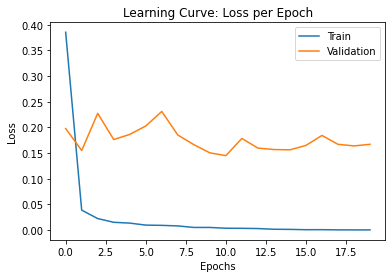

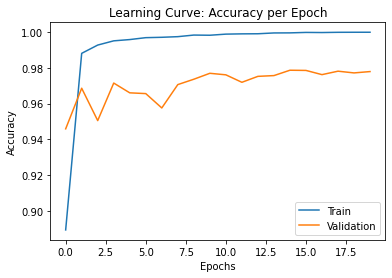

Acuracies for 2000 Augmentations:Train accuracy achieved : 0.9999277906651383 Validation accuracy achieved : 0.9779206859592712 Test accuracy achieved: 0.9771971496437054
[0.9672209026128266, 0.971575613618369, 0.972209026128266, 0.9753760886777514, 0.976326207442597, 0.9750593824228029, 0.9770387965162312, 0.9732383214568487, 0.9743467933491686, 0.9747426761678543, 0.9771971496437054]


In [ ]:
num_of_augmentations_vec = [0, 200, 400, 500, 600, 700, 800, 900, 1000,1500,2000]
test_accuracy_vec = []
val_accuracy_vec = []
for num in num_of_augmentations_vec:
  print(f"---------------------Num of augmentations:{num}---------------------------")
  model_cnn = CNNFinal(32*32, 16, 43)
  model_cnn.to(device) 
  Data_set_train = data_train(num, NUM_OF_LABELS)
  acc_train, acc_val,train_losses, val_losses, train_accuracy, val_accuracy  = train(model_cnn, traindataset = Data_set_train, valdataset = data_set_val, epochs=20)
  plot_learning_curve(epcochs=20, train_losses = train_losses,val_losses = val_losses, train_accs = train_accuracy, val_accs = val_accuracy)
  val_accuracy_vec.append(acc_val)
  test_accuracy = test_eval(model_cnn,test_data)
  print(f"Acuracies for {num} Augmentations:Train accuracy achieved : {acc_train} Validation accuracy achieved : {acc_val} Test accuracy achieved: {test_accuracy}")
  test_accuracy_vec.append(test_accuracy)    
print(test_accuracy_vec)
max_value = max(test_accuracy_vec)
max_idx = test_accuracy_vec.index(max_value)
opt_augmentations = num_of_augmentations_vec[max_idx]



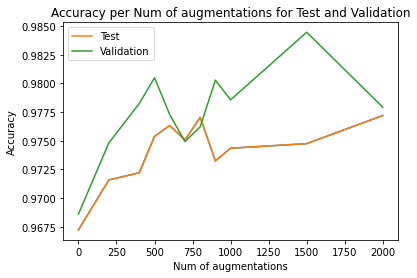

In [ ]:
plt.plot(num_of_augmentations_vec, test_accuracy_vec)
plt.plot(num_of_augmentations_vec, test_accuracy_vec, label="Test")
plt.plot(num_of_augmentations_vec, val_accuracy_vec, label="Validation")
plt.title("Accuracy per Num of augmentations for Test and Validation")
plt.xlabel("Num of augmentations")
plt.ylabel("Accuracy")
plt.legend(loc='best')

Epoch: 0  Train_Accuracy: 0.8893662728249194  Val_Accuracy: 0.9379421221864952 Loss: 0.3855130177240724 Val_Loss: 0.2350829233366408
Epoch: 1  Train_Accuracy: 0.9869481627237361  Val_Accuracy: 0.9585209003215434 Loss: 0.04107664243100904 Val_Loss: 0.28162107778419004
Epoch: 2  Train_Accuracy: 0.9924541245069456  Val_Accuracy: 0.9573419078242229 Loss: 0.023935383138694213 Val_Loss: 0.22675109136923166
Epoch: 3  Train_Accuracy: 0.9938351280361769  Val_Accuracy: 0.9680600214362273 Loss: 0.018710092177902784 Val_Loss: 0.17486212081367788
Epoch: 4  Train_Accuracy: 0.9942593578784897  Val_Accuracy: 0.9698821007502679 Loss: 0.017146730598430075 Val_Loss: 0.19035980328293303
Epoch: 5  Train_Accuracy: 0.9954237334031357  Val_Accuracy: 0.9654876741693462 Loss: 0.014110910514257762 Val_Loss: 0.2189308963899844
Epoch: 6  Train_Accuracy: 0.996542978093493  Val_Accuracy: 0.9687031082529475 Loss: 0.010804755779496215 Val_Loss: 0.2075456695104214
Epoch: 7  Train_Accuracy: 0.99631732392205  Val_Accurac

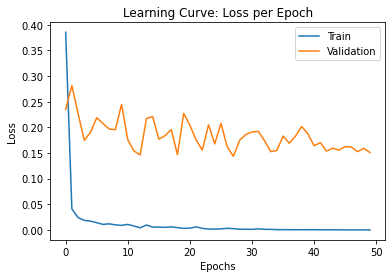

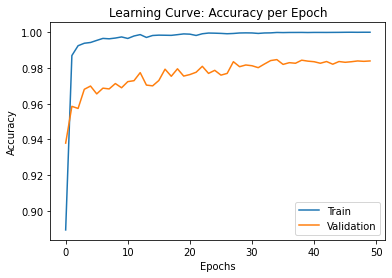

The best number of augmetations per label: 2000 Train accuracy: 0.9999909738331423 Validation accuracy: 0.9839228295819936 Test accuracy: 0.9761678543151228


In [ ]:
model_cnn = CNNFinal(32*32, 16, 43)
model_cnn.to(device) 
Data_set_train = data_train(opt_augmentations, NUM_OF_LABELS)
acc_train, acc_val,train_losses, val_losses, train_accuracy, val_accuracy  = train(model_cnn, traindataset = Data_set_train, valdataset = data_set_val, epochs=50)
plot_learning_curve(epcochs=50, train_losses = train_losses,val_losses = val_losses, train_accs = train_accuracy, val_accs = val_accuracy)
test_accuracy = test_eval(model_cnn,test_data)
print(f"The best number of augmetations per label: {opt_augmentations} Train accuracy: {acc_train} Validation accuracy: {acc_val} Test accuracy: {test_accuracy}")

In [ ]:

def plot_test_images(model,test_data):
  model.eval
  with torch.no_grad():
    plt.figure(figsize=(30,15))
    for i, data in enumerate(test_data, 0):
      img, test_label =  data
      outputs = torch.stack([model(img.view(1,3,32,32).cuda(0))]).sum(0)
      _,pred_idxs = torch.topk(outputs, 1)
      col = 'g'
      if pred_idxs.item() != test_label.item():
        col = 'r'
      plt.subplot(3,4,i+1)
      img = img/255
      plt.imshow(img.permute(1, 2, 0))
      plt.title("true: "+labels[test_label.item()]+" predicted: " +labels[pred_idxs.item()], color = col)



**Results**

Without using the augmented data we generated, we were able to achieve over 96% accuracy. When we used augmented images, we managed to improve our results, and achieved over 97% accuracy.

In order to achieve this result, we undergone a process of twitching the following hyperparameters:
•	No. of epochs
•	Batch size
•	No. of augmented images for each class

We decided on the combination, by iterating over the possibilities and choosing the one that gave the best result. For example, we chose 50 epochs, after witnessing that it is enough for the model to stabilize on a roughly fixed accuracy value.

Additionally, we decided on resizing the images to a size of 32x32 in order to make the data as compact as possible, while still maintaining enough information for our model to process. We chose 32x32 based on other projects done on the same dataset. 

We compared our model to the following benchmark models on Kaggle:


(1)	https://www.kaggle.com/code/lalithmovva/99-accuracy-on-german-traffic-sign-recognition

(2)	https://www.kaggle.com/code/yacharki/traffic-signs-image-classification-96-cnn

(3)	https://www.kaggle.com/code/kar0n7/traffic-signal-recognizer-98-accuracy

(4)	https://www.kaggle.com/code/vrenganathan/german-traffic-sign-99-7-val-97-test-accuracy

(5)	https://www.kaggle.com/code/shivank856/gtsrb-cnn-98-test-accuracy

It seems as we achieved decent results in all of our evaluation matrices, compared to the other models. Accuracy >98% surpassed or parred with all the benchmark models, except for (1) – which managed to achieve over 99% accuracy. 

(5) is the only benchmark that includes a confusion matrix, and it resembles the confusion that we received with our model.



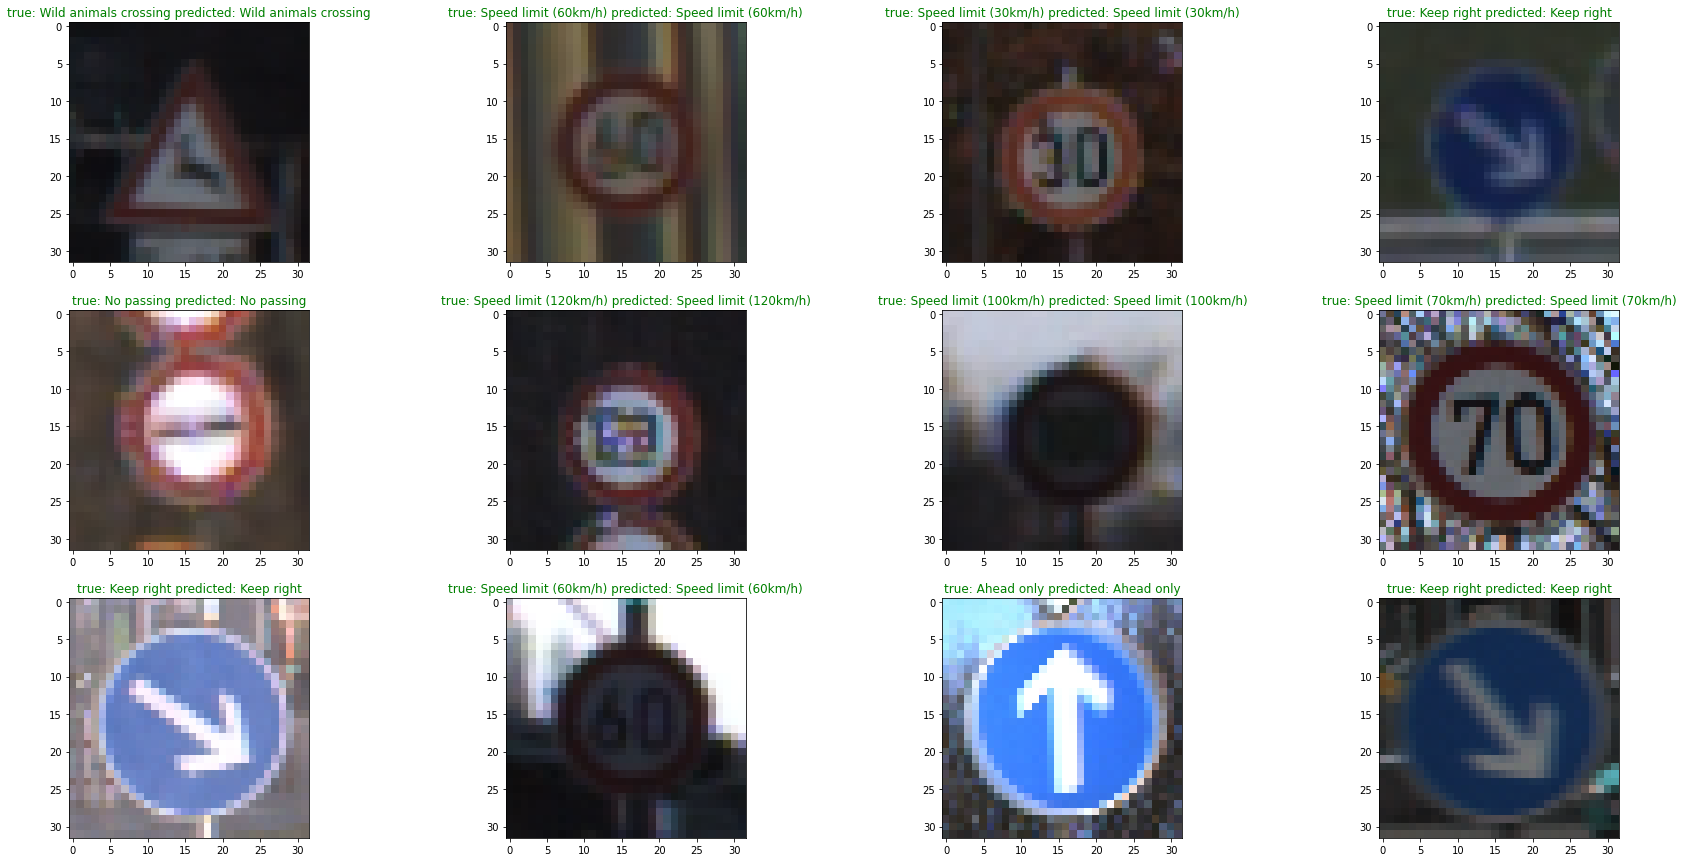

In [ ]:

randomlist = random.sample(range(0, 12630), 12)
test_sampling = []
for i in range(12):
  test_sampling.append(test_data[randomlist[i]])
plot_test_images(model_cnn,test_sampling)


**Result Analysis**

As we mentioned before, we tried different number of epochs, and decided to choose 50 because it was enough to stabilize the accuracy value.

At the beginning, we tried to give the augmented images a random rotation (in the range of (-35°,35°)), but we figured that applying the random rotation causes the augmented data to only decrease the accuracy. So we removed the random rotation from ImageDataGenerator() class, and twitched the other parameters till we saw that using the augmented data enhanced our model.

Additionally, we can see that without using augmented data, we receive substantial Overfitting – while train_accuracy converges rapidly to 1, val_accuracy remains relatively low.

For Ablation study, we modified our model to create three additional models, were changed different parts in our original model. This is what did in each Ablation model:

1) We used only two convolution layers, with a MaxPooling and Batch Norm Layers in between them.

2) We used four convolutional layers, but with stride=2 and without MaxPooling.

3) We used four convolutional layers, but without Dropout.

In all of the Ablation models, we received inferior results of about 95-96% accuracy. This approved that we should include four convolutional layers in our model, without stride, but with MaxPooling and Dropout layers. In particular, the Dropout layer was successful in reducing the amount of Overfitting.



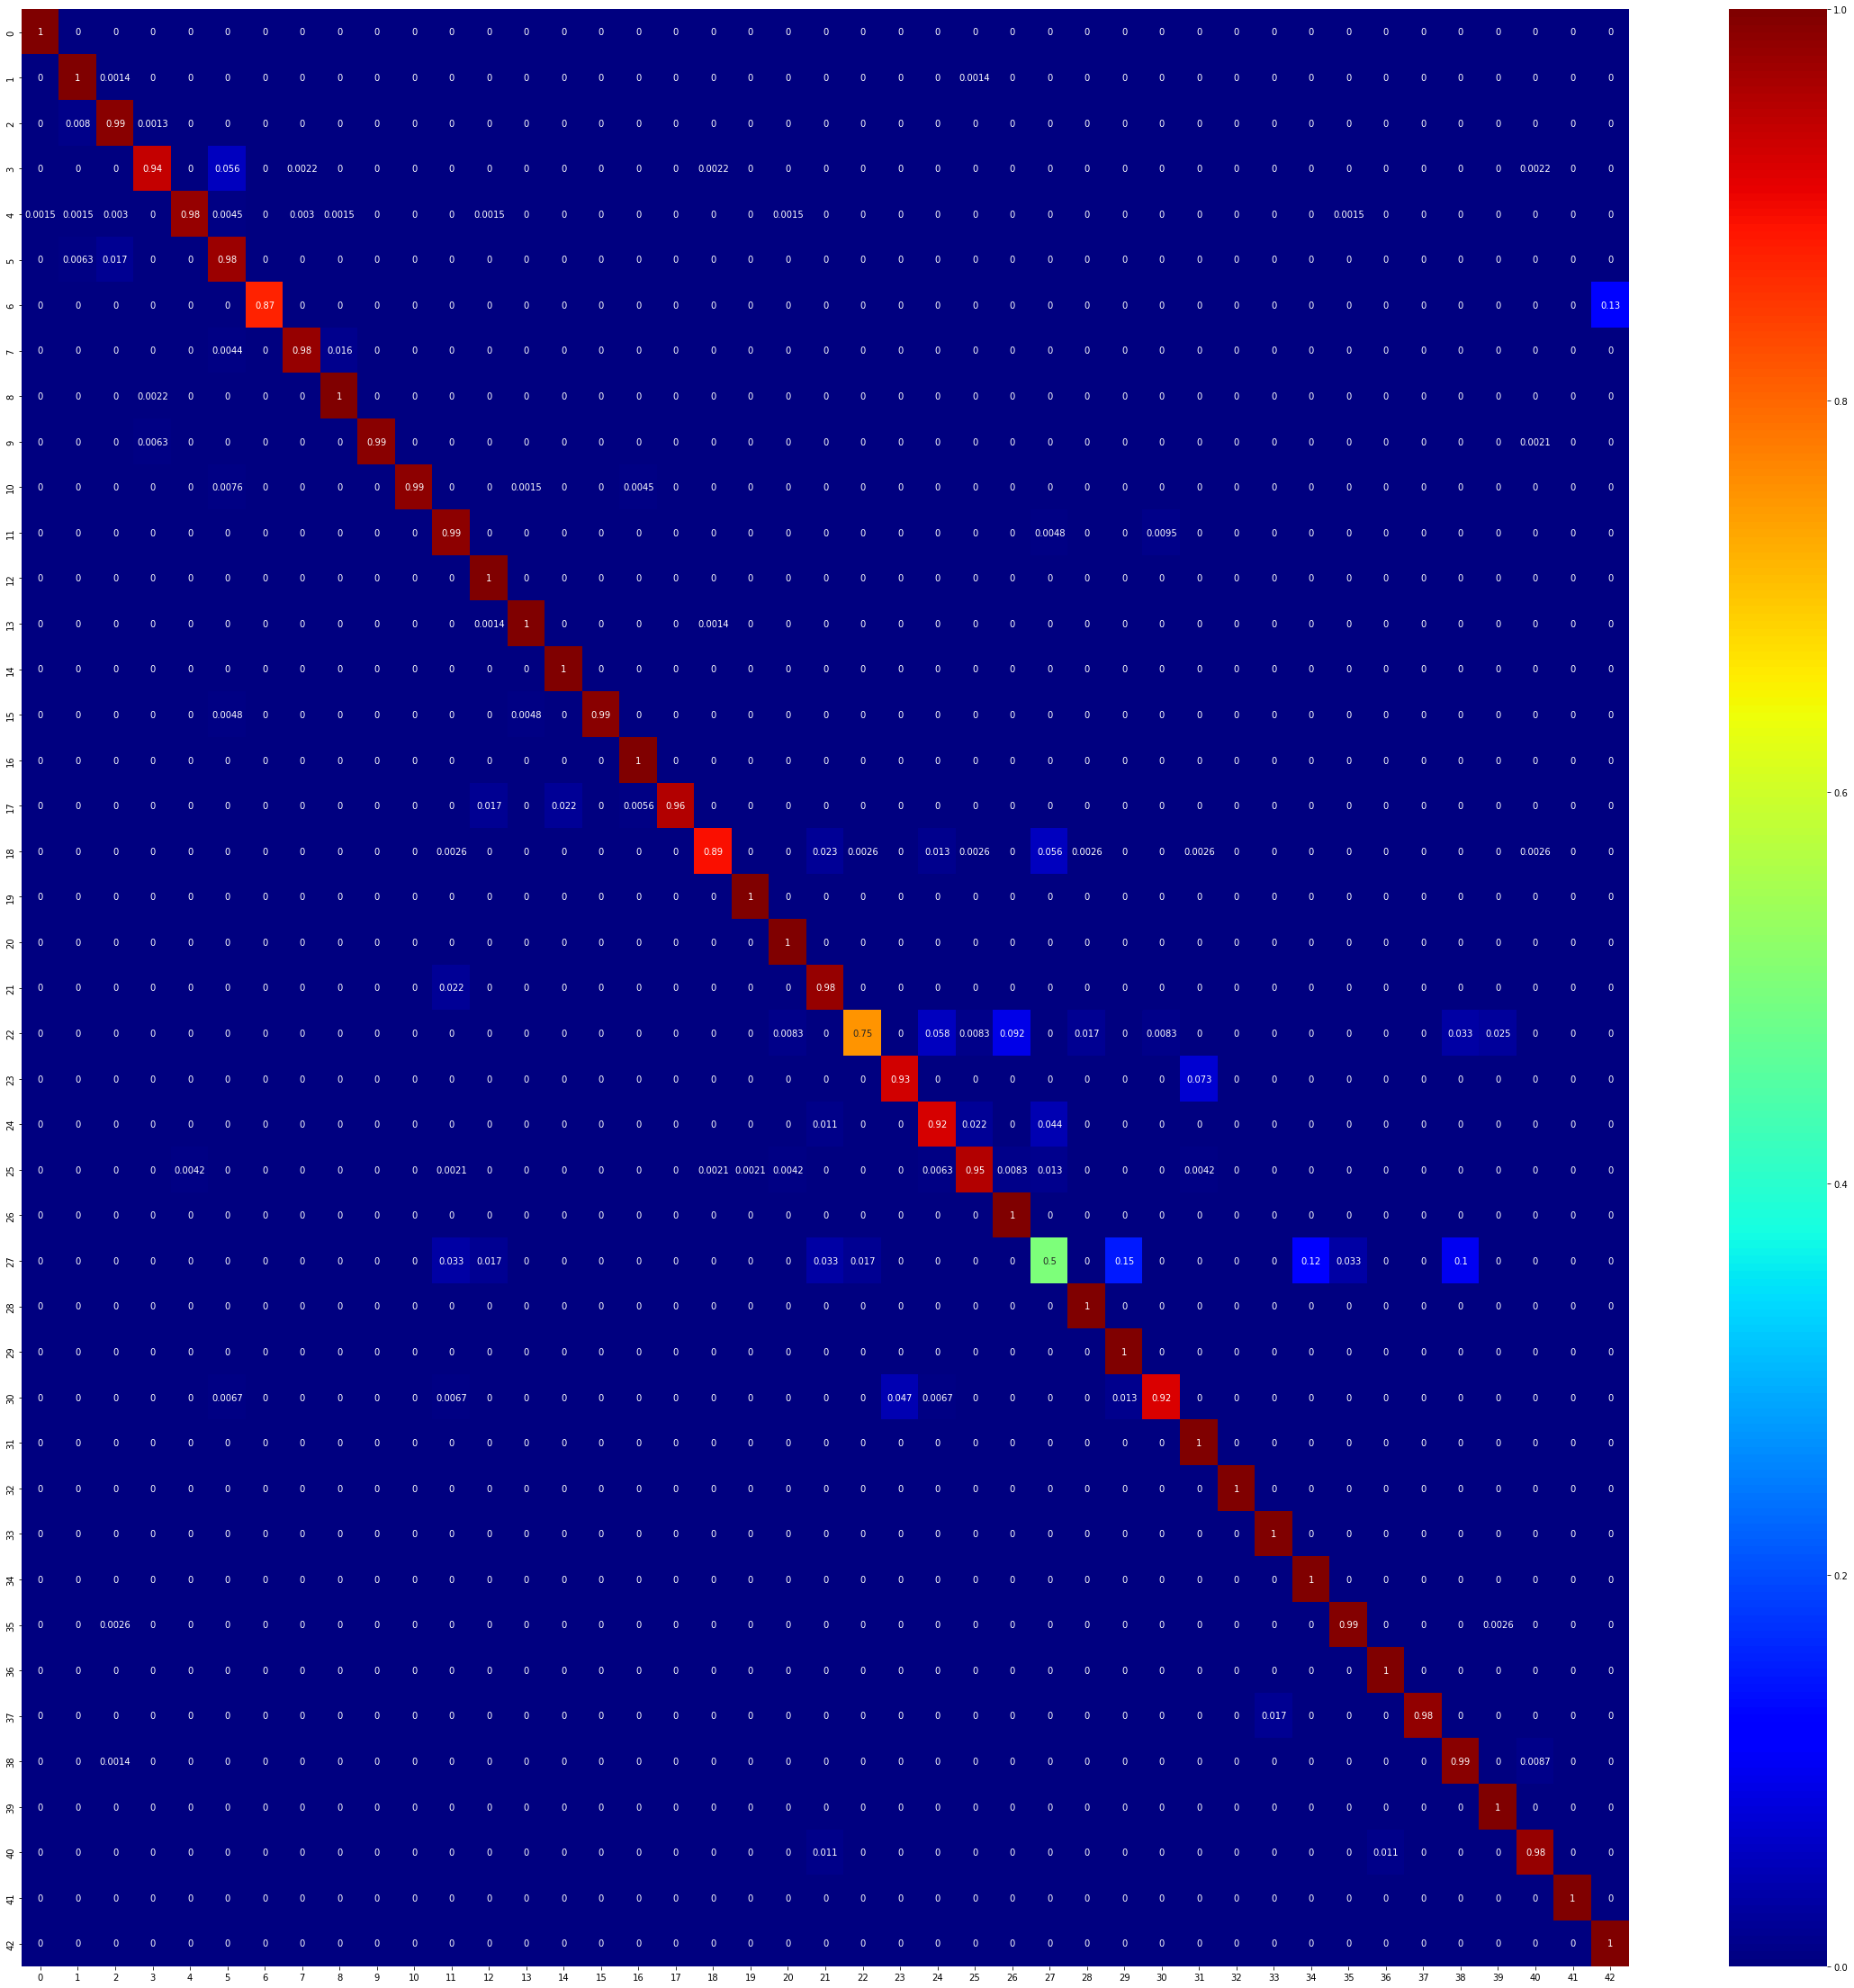

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred_vec = np.zeros(len(test_data))
expected_vec = np.zeros(len(test_data))
for i, data in enumerate(test_data, 0):
      inputs, test_labels =  data
      expected_vec[i] = test_labels.item()
      outputs = torch.stack([model_cnn(inputs.view(1,3,32,32).cuda(0))]).sum(0)
      _,pred_idxs = torch.topk(outputs, 1) 
      pred_vec[i] = pred_idxs.item()


cf = confusion_matrix(expected_vec, pred_vec,normalize='true')
df_cm = pd.DataFrame(cf, index = range(43),  columns = range(43))
plt.figure(figsize = (40,40))
sns.heatmap(df_cm, annot=True, cmap='jet')

In the confusion matrix, we see that we received good results for most classes,
except for class #27 (50%). We assume that it is caused by high resemblance to
other classes, and a small number of original training images (This is why the
resembaling classes have no problem - they a larger number of original training images). 

**Conclusion**

We leraned that the main challenge in the project was to avoid Overfitting by 
employing different ML strategies, such as: Data Augmentation, Dropout layer, 
Max Pooling layers etc.

We gained important practical knowledge, and especially enjoyed exploring the field of Data Augmentation – which we were not familiar with. 

We are in content with the results, but still look forward towards creating more innovative models in our future work in the industry.


**References**

[1] The course's lectures.

[2] The benchmark Kaggle projects mentioned before.